In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import numpy as np
from segmentation_models_pytorch.encoders import get_preprocessing_fn
import segmentation_models_pytorch as smp
from sklearn.preprocessing import LabelEncoder
import random
# image operations
from PIL import Image
import os
import glob
import cv2
from patchify import patchify,unpatchify
import matplotlib

Seed Everthing for Reproducibility

In [2]:
def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(43)

Since we are dealing with dataset of very high resolution, I thuoght the best approach would be sliding window approach.

Where we are creating patches of 256,256 from the dataset, and storing them in seperate folder

In [ ]:
# Patchify

image_train = cv2.imread('Valid_Image/2edf6cc7696c91d86eb86413fa9c82d7.png')
patches = patchify(image_train,(256,256,3),step=256)
for i in range(patches.shape[0]):
    for j in range(patches.shape[1]):
            single_patch = patches[i,j,:,:]
            #print(single_patch.shape)
            cv2.imwrite('Valid_Image_Patches/Val_A_'+str(i)+'_'+str(j)+'.png',single_patch.squeeze())


image = cv2.imread('Valid_Mask/2edf6cc7696c91d86eb86413fa9c82d7_mask.png')
patches = patchify(image,(256,256,3),step=256)
for i in range(patches.shape[0]):
    for j in range(patches.shape[1]):
            single_patch = patches[i,j,:,:]
            #print(single_patch.shape)
            cv2.imwrite('Valid_Mask_Patches/Val_A_'+str(i)+'_'+str(j)+'.png',single_patch.squeeze())



For multiclass, instead of having individual colors as masks, better to scale them down to 0-5, as 6 classes.

In [3]:
def encode_mask_pixel(mask_np,pixel_array):
    '''
    encodes pixel for mask
    '''
    for pixel in pixel_array:
        
        if pixel == 29:
            mask_np[mask_np == pixel] = 1
        
        if pixel == 76:
            mask_np[mask_np == pixel] = 2
        
        if pixel == 149:
            mask_np[mask_np == pixel] = 3
        
        if pixel == 150:
            mask_np[mask_np == pixel] = 4
        
        if pixel == 225:
            mask_np[mask_np == pixel] = 5
    
    return mask_np



Create our dataset using pytoch dataset class

Hardest part to figure out.

Now we load our image patches, one by one, along with masks

Image:

1. Convert BGR to RGB
2. Transformations : Normalise, and totensor()
3. final shape : Batchx3x256x256

Mask: 

1. Load as single channel
2. The values for classes were observed to be:

    Black : 0

    Blue : 29

    Red : 76

    Green: 149

    Gray: 150

    Yellow: 225

3. Remapped the values to 0 → 5
4. one hot encoded the classes
5. Transformations: totensor()
6. Final shape: Batchx6x256x256

Finally, also added features for augementation transforms, model pre-processing, test_loading etc. as required.

In [75]:
# Dataset class
class slide_image(Dataset):
    """Slide images dataset. 
    
    Read images, apply augmentation and preprocessing transformations.
    
    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_values (list): values of classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
    
    """
    
    CLASSES = ['Black','Blue','Red','Green','Gray','Yellow']
    
    '''
    Black : 0
    Blue : 29
    Red : 76
    Green: 149
    Gray: 150
    Yellow: 225
    '''

    def __init__(
            self, 
            images_dir, 
            masks_dir, 
            classes=None, 
            augmentation=None, 
            preprocessing=None,
            transform= None,
            custom_img_path= None,
            true_mask_for_testing = None
    ):
        self.images_dir= images_dir
        self.masks_dir=masks_dir
        self.ids = os.listdir(images_dir)
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
        self.masks_fps = [os.path.join(masks_dir, image_id) for image_id in self.ids]
        
        # convert str names to class values on masks
        self.class_values = [self.CLASSES.index(cls) for cls in classes]
        
        self.augmentation = augmentation
        self.preprocessing = preprocessing
        self.transform = transform
        self.custom_img_path = custom_img_path
        self.true_mask_for_testing = true_mask_for_testing
    
    def __getitem__(self, i):
        
        # read data
        #print(self.images_fps[i])
        if self.custom_img_path:
            image = cv2.imread(self.images_dir+'/'+self.custom_img_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            mask = cv2.imread(self.masks_dir+'/'+self.custom_img_path, 0)
        else:
            image = cv2.imread(self.images_fps[i])
        #image= cv2.imread('./Train_Image_Patches/Train_A_35_7.png')
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        #print(self.masks_fps[i])
        
            mask = cv2.imread(self.masks_fps[i], 0)


        #mask = cv2.imread('./Train_Mask_Patches/Train_A_35_7.png',0)
    
        # encoded pixel masks into 0 to 5
        
        # here it is encoding per image!!! will mess up masks

        # labelencoder = LabelEncoder()
        # h, w = mask.shape
        # print(np.unique(mask))
        # mask_encoded = labelencoder.fit_transform(mask.reshape(-1,1))
        # mask_encoded = mask_encoded.reshape(h, w)
        # mask = mask_encoded
        # print(np.unique(mask))

        # better define custom function to encode pixel
#        print(np.unique(mask))
        mask = encode_mask_pixel(mask_np=mask,pixel_array=np.unique(mask))
#        print(np.unique(mask))

        # extract certain classes from mask 
        masks = [(mask == v) for v in self.class_values] 
        
        # creates a 1-hot encoding for classes
        mask = np.stack(masks, axis=-1).astype('float')
        
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        if self.transform:
            image = self.transform(image)
            mask =torch.tensor(mask.transpose(2,0,1),dtype=torch.float32)
#            image, mask = sample['image'], sample['mask']
        
        #image_tensor=torch.tensor(image.transpose(2,0,1),dtype=torch.float32)
        
        if self.true_mask_for_testing:
            mask = cv2.imread(self.masks_fps[i], 0)
            return image, mask

        return image, mask
        
    def __len__(self):
        return len(self.ids)

Defined paths, will change for colab

In [5]:
DATA_DIR = './'
x_train_dir = os.path.join(DATA_DIR, 'Train_Image_Patches')
y_train_dir = os.path.join(DATA_DIR, 'Train_Mask_Patches')

x_valid_dir = os.path.join(DATA_DIR, 'Valid_Image_Patches')
y_valid_dir = os.path.join(DATA_DIR, 'Valid_Mask_Patches')

Visualisation helper function

In [6]:

def visualize(**images):
    """PLot images in one row."""
    
    norm=plt.Normalize(0,5) # 6 classes
    map_name = matplotlib.colors.LinearSegmentedColormap.from_list("", ["black","red","green","gray","yellow"])
    #map_name = matplotlib.colors.LinearSegmentedColormap.from_list("", ["red"])
    
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image, cmap=map_name, norm=norm)
    plt.show()

In [405]:
# sanity check

# defined initial transforms
transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.5], [0.5])
        ])
train_dataset = slide_image(x_train_dir, y_train_dir, classes=['Black','Blue','Red','Green','Gray','Yellow'],custom_img_path = 'Train_A_1_13.png',transform=transform)

#image, mask=next(iter(train_dataset))
image, mask=train_dataset[60]
print(image.shape,mask.shape)
print(type(image),type(mask))
print(np.unique(image),np.unique(mask))

torch.Size([3, 256, 256]) torch.Size([6, 256, 256])
<class 'torch.Tensor'> <class 'torch.Tensor'>
[-0.7490196  -0.7176471  -0.7019608  -0.69411767 -0.6784314  -0.67058825
 -0.6627451  -0.654902   -0.64705884 -0.6392157  -0.6313726  -0.62352943
 -0.6156863  -0.60784316 -0.6        -0.5921569  -0.58431375 -0.5764706
 -0.5686275  -0.56078434 -0.5529412  -0.54509807 -0.5372549  -0.5294118
 -0.52156866 -0.5137255  -0.5058824  -0.4980392  -0.49019605 -0.4823529
 -0.47450978 -0.46666664 -0.4588235  -0.45098037 -0.44313723 -0.4352941
 -0.42745095 -0.41960782 -0.41176468 -0.40392154 -0.3960784  -0.38823527
 -0.38039213 -0.372549   -0.36470586 -0.35686272 -0.3490196  -0.34117645
 -0.3333333  -0.32549018 -0.31764704 -0.3098039  -0.30196077 -0.29411763
 -0.2862745  -0.27843136 -0.27058822 -0.26274508 -0.25490195 -0.24705881
 -0.23921567 -0.23137254 -0.2235294  -0.21568626 -0.20784312 -0.19999999
 -0.19215685 -0.18431371 -0.17647058 -0.16862744 -0.1607843  -0.15294117
 -0.14509803 -0.1372549  -0.12

In [34]:
class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        Returns:
            Tensor: Normalized image.
        """
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
            # The normalize code -> t.sub_(m).div_(s)
        return tensor

Checking the data.
Here we are able to plot multiple segmentation maps, included example of Black, Blue, Grey.
The "red" is just used for highlights

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


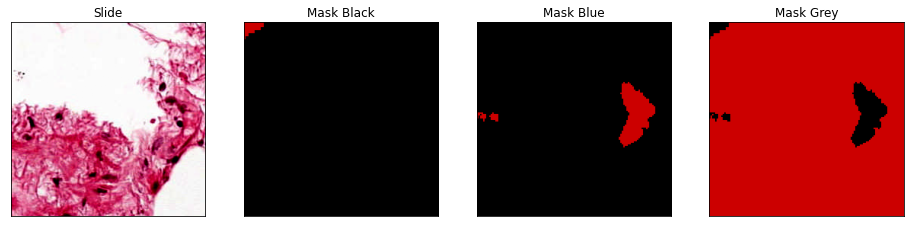

In [413]:
unorm = UnNormalize(mean =[0.5],std=[0.5])
image = unorm(image)
visualize(slide = image.numpy().transpose(1,2,0),mask_black=mask.numpy().transpose(1,2,0)[...,0].squeeze(),mask_blue = mask.numpy().transpose(1,2,0)[...,1].squeeze(),mask_grey = mask.numpy().transpose(1,2,0)[...,4].squeeze())

Loading dataloaders, and sanity checking, with basic transforms. Since we will be using pre-traiend backbone, the transformations will change

In [414]:

train_dataset = slide_image(x_train_dir, y_train_dir, classes=['Black','Blue','Red','Green','Gray','Yellow'],transform=transform)

val_dataset = slide_image(x_valid_dir, y_valid_dir, classes=['Black','Blue','Red','Green','Gray','Yellow'],transform=transform)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=12)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=True, num_workers=12)

In [418]:
train_image_batch,train_mask_batch=next(iter(train_loader))
print(train_image_batch.shape)
print(train_mask_batch.shape)
print('Train dataset size',len(train_dataset))
print('Valid dataset size',len(val_dataset))

torch.Size([8, 3, 256, 256])
torch.Size([8, 6, 256, 256])
Train dataset size 4376
Valid dataset size 5281


Defined augmentations for model preprocessing pipeline

In [7]:
import albumentations as albu

def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')

def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn: data normalization function 
        
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        albu.Lambda(image=preprocessing_fn),
        albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform)

Went on to search for various SOTA architectures, but first wanted to establish a minimal baseline. Hence used [segmenation_models](https://smp.readthedocs.io/en/latest/) given architectures  

Used transfer learning with UNET as decoder and encoder as ResNet32(that is all I could fit in my laptop). Utilised the pre-trained weights from "imagenet".  

Removed the head of ResNet, with final layer as fully convolutional, which is then passed to UNET encoder to upsample.  

Output layer of UNET was modified to give 6 feature maps as output with softmax. Same shape as label_mask earlier.

Model had total 24M parameters

In [8]:
#! data pre-processing and defining model

ENCODER = 'resnet34'
ENCODER_WEIGHTS = 'imagenet'
CLASSES=['Black','Blue','Red','Green','Gray','Yellow']
ACTIVATION = 'softmax' # could be None for logits or 'softmax2d' for multicalss segmentation
DEVICE = 'cuda'

model_unet_rn34 = smp.Unet(
    encoder_name="resnet34",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=3,                  # model input channels (1 for gray-scale images, 3 for RGB, 
    classes=len(CLASSES),                      # model output channels (number of classes in your dataset)
    activation=ACTIVATION
)

preprocess_input = get_preprocessing_fn(ENCODER,ENCODER_WEIGHTS)

The architecture

In [22]:
model_unet_rn34

Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

Can see the encoder as ResNet, and at final layer, have added 6 channel output, with each class having its respective channel.  


Summary of model

In [24]:
from torchsummary import summary
summary(model_unet_rn34, input_size=(3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           9,408
       BatchNorm2d-2         [-1, 64, 128, 128]             128
              ReLU-3         [-1, 64, 128, 128]               0
         MaxPool2d-4           [-1, 64, 64, 64]               0
            Conv2d-5           [-1, 64, 64, 64]          36,864
       BatchNorm2d-6           [-1, 64, 64, 64]             128
              ReLU-7           [-1, 64, 64, 64]               0
            Conv2d-8           [-1, 64, 64, 64]          36,864
       BatchNorm2d-9           [-1, 64, 64, 64]             128
             ReLU-10           [-1, 64, 64, 64]               0
       BasicBlock-11           [-1, 64, 64, 64]               0
           Conv2d-12           [-1, 64, 64, 64]          36,864
      BatchNorm2d-13           [-1, 64, 64, 64]             128
             ReLU-14           [-1, 64,

Checking the model pre-processing function

In [8]:
preprocess_input
#it's applying it's own normalisation
# can also use the same normalisation numbers in dataclass to avoid

functools.partial(<function preprocess_input at 0x7fdcad200a60>, input_space='RGB', input_range=[0, 1], mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

Creating new dataloaders with models pre-processors. Since we are using pre-trained , we can discard earlier transformations.

In [9]:
# transform = transforms.Compose([
#             transforms.ToTensor()
#           #  transforms.Normalize([0.5], [0.5]) #since backbone is already doing normalisation
#         ])

# withuot augmentations



train_dataset_2 = slide_image(x_train_dir, y_train_dir, classes=CLASSES,preprocessing=get_preprocessing(preprocess_input))

train_loader_2 = DataLoader(train_dataset_2, batch_size=32, shuffle=True, num_workers=12)

val_dataset_2 = slide_image(x_valid_dir, y_valid_dir, classes=CLASSES,preprocessing=get_preprocessing(preprocess_input))

val_loader_2 = DataLoader(val_dataset_2, batch_size=32, shuffle=True, num_workers=12)

#!! FINALLY DATA LOADERS DONE

In [10]:
#! sanity check
image,mask=next(iter(train_dataset_2))
print(image.shape,mask.shape)
print(type(image),type(mask))
print(np.unique(image),np.unique(mask))

(3, 256, 256) (6, 256, 256)
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
[2.2489083 2.4285715 2.64     ] [0. 1.]


Loss:

Used dice loss for training.

Used metrics  = IoU , cant used accuracy because of high class imbalance.

Optimiser = Adam

In [11]:
loss = smp.utils.losses.DiceLoss()

In [12]:
loss = smp.utils.losses.DiceLoss()

metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
]


optimizer = torch.optim.Adam([ 
    dict(params=model_unet_rn34.parameters(), lr=0.0001),
])




In [13]:
train_epoch = smp.utils.train.TrainEpoch(
    model_unet_rn34, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model_unet_rn34, 
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)

In [14]:


# train model for 40 epochs, ended at 27th

max_score = 0

for i in range(0, 40):
    
    print('\nEpoch: {}'.format(i))
    train_logs = train_epoch.run(train_loader_2)
    valid_logs = valid_epoch.run(val_loader_2)
    
    # do something (save model, change lr, etc.)
    if max_score < valid_logs['iou_score']:
        max_score = valid_logs['iou_score']
        torch.save(model_unet_rn34, './best_model_unet_rn34.pth')
        print('Model saved!')
        
    if i == 25:
        optimizer.param_groups[0]['lr'] = 1e-5
        print('Decrease decoder learning rate to 1e-5')




Epoch: 0
train:   0%|          | 0/137 [00:00<?, ?it/s]/home/shreeyash-legion/miniconda3/envs/graphdrp/lib/python3.8/site-packages/segmentation_models_pytorch/base/modules.py:102: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self.activation(x)
valid: 100%|██████████| 166/166 [00:33<00:00,  4.95it/s, dice_loss - 0.266, iou_score - 0.786]
Model saved!

Epoch: 1
valid: 100%|██████████| 166/166 [00:34<00:00,  4.85it/s, dice_loss - 0.143, iou_score - 0.8399]
Model saved!

Epoch: 2
valid: 100%|██████████| 166/166 [00:31<00:00,  5.28it/s, dice_loss - 0.1219, iou_score - 0.8246]

Epoch: 3
valid: 100%|██████████| 166/166 [00:29<00:00,  5.53it/s, dice_loss - 0.1198, iou_score - 0.8599]
Model saved!

Epoch: 4
valid: 100%|██████████| 166/166 [00:30<00:00,  5.47it/s, dice_loss - 0.1039, iou_score - 0.8469]

Epoch: 5
valid: 100%|██████████| 166/166 [00:29<00:00,  5.61it/s, dice_loss - 0.1037, iou_score - 0.8635]
Mo

KeyboardInterrupt: 

## Training summary

For the best model, on **validation set**:

dice_loss = 0.09517
**dice_coeff = 0.9048**
**IOU/Jaccard = 0.8693**

But from general observation.
The model on 1st epoch was underfitting , as observed by IoU on train vs test.\

Then from 2nd epoch onwards model started overfitting, and once we reached training_iou ~ 0.95, all hopes were lost. Since only  = 1 - 0.95 →i.e val_iou increase of around 0.05 at best case. 

Hence model needed reguralisation techniques, like hard augmentations, higher dropouts.

PS: I missed to capture the running training loss and IoU, Hence no Plots, wanted to rerun but no time :( 

### Best part in any modelling, prediction pipelines


Took any random image and tried to observe the segmentation.

Had to take care of shapes, device etc

For the predicted tensor, since we get 6 segmentation maps, we have to do depthwise argmax, to get final segmentation map to compare with ground truth mask


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


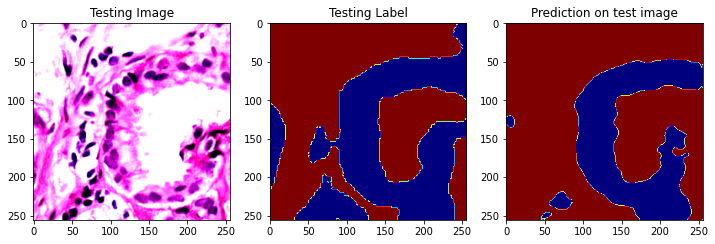

In [82]:
# Random testing


test_img_number = random.randint(0, len(val_dataset_2))

test_img,ground_truth = val_dataset_2[test_img_number]

image_input = torch.from_numpy(test_img).to(DEVICE).unsqueeze(0)

true_mask=ground_truth.round().transpose(1,2,0)
true_mask_argmax = np.argmax(true_mask,axis=2)


predicted_mask = model_unet_rn34.predict(image_input)
predicted_mask = (predicted_mask.squeeze().cpu().numpy().round().transpose(1,2,0))
predicted_mask_argmax = np.argmax(predicted_mask,axis=2)




plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img.transpose(1,2,0), cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(true_mask_argmax, cmap='jet')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(predicted_mask_argmax, cmap='jet')
plt.show()

### Now I wanted to repatch our big image, and visualise

Hence first wrote a function that predicts over individual patches:

In [221]:
def single_patch_prediction(single_patch,single_mask,model):
    '''single patch data processing pipeline
    Args:
        
    '''
    # converting mask
#    single_patch = cv2.cvtColor(single_patch, cv2.COLOR_BGR2RGB)
    mask=single_mask
    #print(mask.shape)
    class_values = [CLASSES.index(cls) for cls in CLASSES]
    mask = encode_mask_pixel(mask_np=mask,pixel_array=np.unique(mask))
    # masks = [(mask == v) for v in class_values] 
    # mask = np.stack(masks, axis=-1).astype('float')
    print(mask.shape)
    
    mask_expand=np.expand_dims(mask,axis=2)
    print(mask_expand.shape)
    sample_patch = get_preprocessing(preprocess_input)(image= single_patch,mask = mask_expand )
    #print(np.expand_dims(mask,axis=2).shape)
    single_patch_tensor = torch.tensor(sample_patch['image'],dtype=torch.float32)
    #print(single_patch_tensor.shape)
    # single_patch_mask = sample_patch['mask']
    # print('sample patch mask shape',single_patch_mask.shape)

    predicted_patch=model.predict(single_patch_tensor.to(DEVICE).unsqueeze(0))

    predicted_patch = (predicted_patch.squeeze().cpu().numpy().round().transpose(1,2,0))
    predicted_patch_argmax = np.argmax(predicted_patch,axis=2)
    #print(predicted_patch_argmax.shape)

    return single_patch,single_mask,predicted_patch_argmax

Trying with single patch, without any dataloader, it works

(256, 256)
(256, 256, 1)


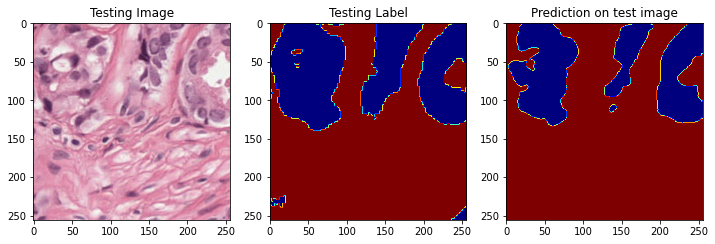

In [220]:
# trying for single image pipeline, without dataloader

single_patch = cv2.imread('./Valid_Image_Patches/Val_B_22_25.png')
single_mask = cv2.imread('./Valid_Mask_Patches/Val_B_22_25.png',0)

single_patch = cv2.cvtColor(single_patch, cv2.COLOR_BGR2RGB)

single_patch,single_mask,predicted_patch_argmax = single_patch_prediction(single_patch,single_mask,model_unet_rn34)

plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(single_patch, cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(mask, cmap='jet')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(predicted_patch_argmax, cmap='jet')
plt.show()

## But not able to make it work with entire image :(

facing strange error, which I did not earlier, otherwise end -to -end pipeline was almost complete

Would apprecite your help in solving this


In [197]:
#DIAGNOSE

large_image = cv2.imread('Valid_Image/2edf6cc7696c91d86eb86413fa9c82d7.png')
single_mask = cv2.imread('./Valid_Mask_Patches/Val_B_22_25.png',0) # dummy mask

image = cv2.cvtColor(large_image, cv2.COLOR_BGR2RGB)

#This will split the image into small images of shape [3,3]
patches = patchify(image,(256,256,3),step=256)  #Step=256 for 256 patches means no overlap

predicted_patches = [] #create an empty list, where will fill patach predictions 1 by 1
for i in range(patches.shape[0]):
    for j in range(patches.shape[1]):
        print(i,j)
        
        single_patch = patches[i,j,:,:]       

        single_patch_prediction(single_patch,single_mask)
        

        predicted_patches.append(predicted_patch_argmax)

# Restich the image
predicted_patches = np.array(predicted_patches)

predicted_patches_reshaped = np.reshape(predicted_patches, (patches.shape[0], patches.shape[1], 128,128) )


reconstructed_image = unpatchify(predicted_patches_reshaped, large_image.shape)

plt.imshow(reconstructed_image, cmap='gray')

0 0
(256, 256)
(256, 256, 1)


ValueError: axes don't match array

*More ToDO:  *

1. Reguralisations: Augementations, more dropouts etc.  
2. GAP to remove size constraints    
4. Cropping as preprocessing step (remoe the white backround)  
5. Better patching algorithm (can see squares in output)  
6. Backround black different from class  "black", especially image 2 in training  
7. Class balance using class_weight   
8. Biomedical pretrained weights  
9. LR schedular  








More models to try:

[https://github.com/PingoLH/FCHarDNet](https://github.com/PingoLH/FCHarDNet) 

[https://github.com/DengPingFan/PraNet](https://github.com/DengPingFan/PraNet) 

[https://github.com/jnkl314/DeepLabV3FineTuning](https://github.com/jnkl314/DeepLabV3FineTuning) 

[https://github.com/fregu856/deeplabv3](https://github.com/fregu856/deeplabv3)

[https://github.com/YudeWang/deeplabv3plus-pytorch](https://github.com/YudeWang/deeplabv3plus-pytorch) 

[https://github.com/YudeWang/semantic-segmentation-codebase/tree/main/experiment/deeplabv3%2Bvoc](https://github.com/YudeWang/semantic-segmentation-codebase/tree/main/experiment/deeplabv3%2Bvoc)

Transformer+Unet: https://github.com/Beckschen/TransUNet/blob/main/trainer.py

